In [1]:
import sys
import numpy as np 
from matplotlib import pyplot as plt 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import h5py # used in the Data Visualization section 
from astropy.coordinates import SkyCoord
import astropy
from astropy.io import fits,ascii,votable
from astropy import units as u 
from astropy import constants as const
from astropy.table import Table
from astropy.cosmology import Planck15 as cosmo

plt.style.use('../cooper-paper.mplstyle')

In [2]:
notes = Table.read('../cooper_werls_notes.csv',format='csv')

In [83]:
targs = notes[notes['mp']>0]
wp = notes[notes['mp']>300]
mp = notes[notes['mp']>800]

In [41]:
# load all the idl files

# cosmos
cfile = '/Users/oc4858/werls/COSMOS_F21.idl'
cidl = scipy.io.readsav(cfile).cat

# uds
ufile = '/Users/oc4858/werls/UDS_candidates_all.idl'
uidl = scipy.io.readsav(ufile).fobj

# egs
efile = '/Users/oc4858/Library/CloudStorage/Box-Box/treasurechest/egs/EGS_F22_trimmed.idl'
pzfile = '/Users/oc4858/werls/EGS_F22_pz.idl'
ezfile = '/Users/oc4858/Library/CloudStorage/Box-Box/treasurechest/egs/EGS_F22_EAZYSED.idl'
pz = scipy.io.readsav(pzfile)
ez = scipy.io.readsav(ezfile)
eidl = scipy.io.readsav(efile).cat

In [93]:
# select object
objs = targs['obj']
MUVs = []
Jmags = []
d2ds = []
photzs = []
zpdfs = []
zarrays = []
 
for obj_name in objs:  

    # select object
    idx = np.where(targs['obj']==obj_name)[0]
    zguess = targs['zguess'][idx]
    wra = float(targs['objra'][idx]); wdec = float(targs['objdec'][idx])
    print('working on object',obj_name,'with zguess = ',zguess)
    
    if targs['mask'][idx][0][:-2] == 'wmmc':
        # load best fit sed
        idl = cidl
        wvl = idl.photz[0].templates[0].lam_rest[0]*u.AA
        fnu_mods = idl.photz[0].templates[0].model[0]*u.erg/u.s/u.Hz/u.cm**2
        
    elif targs['mask'][idx][0][:-2] == 'wmmu':
        # load best fit sed
        idl = uidl
        wvl = idl.photz[0].lam_rest_model[0]*u.AA
        fnu_mods = idl.photz[0].model[0]*u.erg/u.s/u.Hz/u.cm**2

    elif targs['mask'][idx][0][:-2] == 'wmme':
        # load best fit sed
        idl = eidl
        wvl = ez.lam_rest*u.AA
        fnu_mods = ez.model*u.erg/u.s/u.Hz/u.cm**2
     
    # load catalog ra/dec
    catra = idl.ra[0]; catdec = idl.dec[0]
    
    # crossmatch
    c = SkyCoord(ra=catra*u.degree, dec=catdec*u.degree)
    catalog = SkyCoord(ra=wra*u.degree, dec=wdec*u.degree)
    ind, d2d, d3d = catalog.match_to_catalog_sky(c)
    d2ds.append(d2d)
    
    if d2d > 1*u.arcsec:
        print("!! xmatch to source is > 1 arcsec !!")
        Jmags.append(-99)
        MUVs.append(-99)
        photzs.append(-99)
        zpdfs.append(-99)
        pass
    else:
        print('distance to xmatch is ',d2d.to(u.arcsec))
        
        # load fluxes
        fnu_obs = [idl.flux[0][0][i][ind] for i in range(len(idl.flux[0][0]))]*u.nJy
        fnu_obserr = [idl.dflux[0][0][i][ind] for i in range(len(idl.dflux[0][0]))]*u.nJy
        filt_name = idl.flux[0].dtype.names
        filt_lambda = [.592188,.804553,1.055025,1.248607,1.392321,1.537034,3.537841,4.478049]*u.um
        filt_fwhm = [.232293,.185835,.291703,.300520,.394088,.287418,.743171,1.009682]*u.um
        
        
        if targs['mask'][idx][0][:-2] == 'wmme':
            # load zpdf
            za = ez.za[ind]
            zarr = pz.zgrid
            zpdf = pz.pz[ind]
        else:
            # load zpdf
            za = idl.photz[0].za[0][ind]
            zarr = idl.photz[0].zgrid[0]
            zpdf = idl.photz[0].pz[0][ind]
        
        photzs.append(za)
        zarrays.append(zarr)
        zpdfs.append(zpdf)
        zcalc = [float(zguess) if (zguess>0)==True else za][0]
        
        # find mags
        Jmag = (idl.flux[0].FJ[0][ind]*u.nJy).to(u.ABmag) # apparent J mag
        Jmags.append(Jmag.value)
        MUV = (Jmag.value)-(cosmo.distmod(zcalc).value)+(2.5*np.log10(1+zcalc)) # abs UV mag
        MUVs.append(MUV)

working on object M_WP551495 with zguess =  zguess
------
  7.43
!! xmatch to source is > 1 arcsec !!
working on object B_WP450980 with zguess =  zguess
------
  7.09
!! xmatch to source is > 1 arcsec !!
working on object L_WP693466 with zguess =  zguess
------
   7.3
!! xmatch to source is > 1 arcsec !!
working on object c2020_pz_0.664_22.8_826089 with zguess =  zguess
------
 0.666
distance to xmatch is  [0.0434726arcsec]
working on object L_WP930991 with zguess =  zguess
------
    --
distance to xmatch is  [0.0866359arcsec]
working on object c2020_pz_1.65_22.6_640174 with zguess =  zguess
------
  1.64
!! xmatch to source is > 1 arcsec !!
working on object c2020_pz_4.25_27.1_702146 with zguess =  zguess
------
    --
!! xmatch to source is > 1 arcsec !!
working on object c2020_pz_0.486_24.7_889105 with zguess =  zguess
------
 0.506
distance to xmatch is  [0.212567arcsec]
working on object c2020_pz_4.82_26.4_510074 with zguess =  zguess
------
    --
!! xmatch to source is > 1 arcs

distance to xmatch is  [0.0359803arcsec]
working on object CAND_L39354 with zguess =  zguess
------
    --
distance to xmatch is  [0.0382503arcsec]
working on object c2020_pz_4.13_26.7_925386 with zguess =  zguess
------
    --
distance to xmatch is  [0.128826arcsec]
working on object CAND_L40113 with zguess =  zguess
------
  8.08
distance to xmatch is  [0.0518897arcsec]
working on object CAND_M46246 with zguess =  zguess
------
  8.04
distance to xmatch is  [0.0179845arcsec]
working on object CAND_M45034 with zguess =  zguess
------
  7.43
distance to xmatch is  [0.0499808arcsec]
working on object c2020_pz_4.50_27.5_925679 with zguess =  zguess
------
    --
!! xmatch to source is > 1 arcsec !!
working on object CAND_M34981 with zguess =  zguess
------
    --
distance to xmatch is  [0.0402426arcsec]
working on object c2020_pz_0.973_24.8_547470 with zguess =  zguess
------
    --
distance to xmatch is  [0.0402426arcsec]
working on object CAND_L38907 with zguess =  zguess
------
    --

!! xmatch to source is > 1 arcsec !!
working on object c2020_pz_1.71_25.3_517864 with zguess =  zguess
------
    --
!! xmatch to source is > 1 arcsec !!
working on object jw_m440697 with zguess =  zguess
------
    --
distance to xmatch is  [0.0620905arcsec]
working on object CAND_L58875 with zguess =  zguess
------
    --
distance to xmatch is  [0.0108arcsec]
working on object c2020_pz_4.77_26.2_388585 with zguess =  zguess
------
    --
!! xmatch to source is > 1 arcsec !!
working on object M_WPCAND-4775 with zguess =  zguess
------
    --
distance to xmatch is  [0.144975arcsec]
working on object L_WPCAND-5916 with zguess =  zguess
------
    --
distance to xmatch is  [0.132047arcsec]
working on object L_WPCAND-10635 with zguess =  zguess
------
    --
distance to xmatch is  [0.144178arcsec]
working on object L_WPCAND-2383 with zguess =  zguess
------
    --
distance to xmatch is  [0.122952arcsec]
working on object M_WPCAND-8677 with zguess =  zguess
------
    --
distance to xmatch

distance to xmatch is  [0.0145635arcsec]
working on object NSFin_EGS_SF_z6_7061 with zguess =  zguess
------
  8.08
distance to xmatch is  [0.00217709arcsec]
working on object NSFin_EGS_SF_z6_14490 with zguess =  zguess
------
    --
distance to xmatch is  [0.052361arcsec]
working on object B_W44678 with zguess =  zguess
------
 7.172
distance to xmatch is  [0.0112948arcsec]
working on object NSFin_EGS_SF_z6_32303 with zguess =  zguess
------
   7.3
distance to xmatch is  [0.022583arcsec]
working on object NSFin_EGS_SF_z6_40811 with zguess =  zguess
------
    --
distance to xmatch is  [0.0225645arcsec]
working on object sf_26.5_9041 with zguess =  zguess
------
  7.85
distance to xmatch is  [0.0056507arcsec]
working on object NSFin_EGS_SF_z7_48766 with zguess =  zguess
------
    --
distance to xmatch is  [0.0261191arcsec]
working on object NSFin_EGS_SF_z6_14247 with zguess =  zguess
------
    --
distance to xmatch is  [0.016951arcsec]
working on object NSFin_EGS_SF_z7_13433 with zgu

Text(0, 0.5, 'MUV')

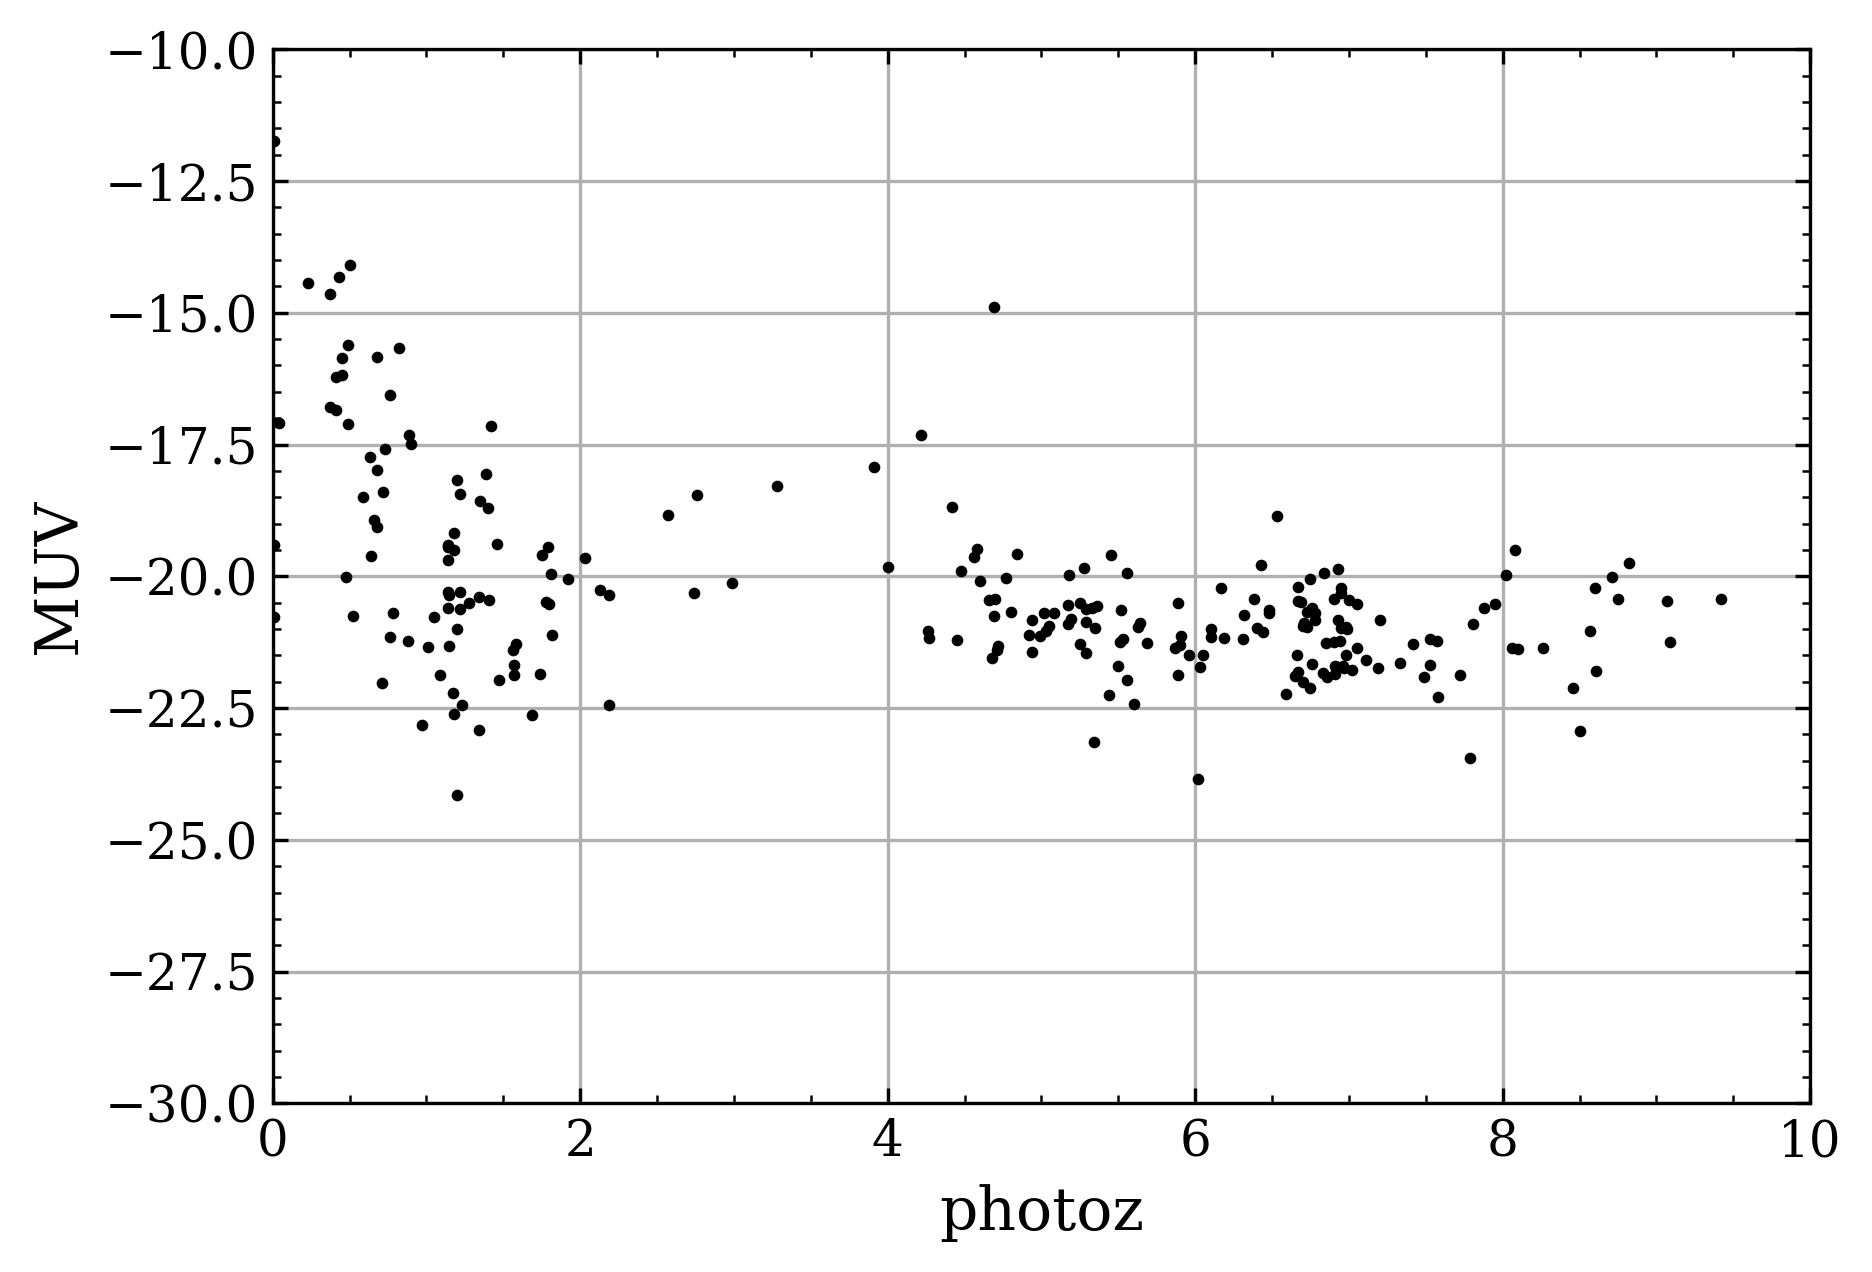

In [116]:
allcand = Table([objs,MUVs,Jmags,photzs],names=('obj','MUV_cand','Jmag_cand','pz_cand'))
plt.plot(allcand['pz_cand'],allcand['MUV_cand'],'k.')
plt.ylim(-30,-10)
plt.xlim(0,10)
plt.xlabel('photoz')
plt.ylabel('MUV')

In [114]:
# Specify the version of the catalog and the folder with the input/output files
catversion = 'Farmer'  # this string can be either 'Classic' or 'Farmer'
dir_in = '/Users/oc4858/Library/CloudStorage/Box-Box/treasurechest/cosmos/COSMOS2020_R1/'  
#dir_out = './'  # the directory where the output of this notebook will be stored
fitversion = 'lp'  
cat0 = Table.read(dir_in+'COSMOS2020_FARMER_R1_v2.0.fits',format='fits',hdu=1)

KeyboardInterrupt: 

In [ ]:
# select object
objs = targs['obj']
MUVs = []
Jmags = []
d2ds = []
photzs = []
zpdfs = []
zarrays = []
 
for obj_name in objs:  

    # select object
    idx = np.where(targs['obj']==obj_name)[0]
    zguess = targs['zguess'][idx]
    wra = float(targs['objra'][idx]); wdec = float(targs['objdec'][idx])
    print('working on object',obj_name,'with zguess = ',zguess)
    
    if targs['mask'][idx][0][:-2] == 'wmmc':
        # load best fit sed
        idl = cidl
        wvl = idl.photz[0].templates[0].lam_rest[0]*u.AA
        fnu_mods = idl.photz[0].templates[0].model[0]*u.erg/u.s/u.Hz/u.cm**2
        
    elif targs['mask'][idx][0][:-2] == 'wmmu':
        # load best fit sed
        idl = uidl
        wvl = idl.photz[0].lam_rest_model[0]*u.AA
        fnu_mods = idl.photz[0].model[0]*u.erg/u.s/u.Hz/u.cm**2

    elif targs['mask'][idx][0][:-2] == 'wmme':
        # load best fit sed
        idl = eidl
        wvl = ez.lam_rest*u.AA
        fnu_mods = ez.model*u.erg/u.s/u.Hz/u.cm**2
     
    # load catalog ra/dec
    catra = idl.ra[0]; catdec = idl.dec[0]
    
    # crossmatch
    c = SkyCoord(ra=catra*u.degree, dec=catdec*u.degree)
    catalog = SkyCoord(ra=wra*u.degree, dec=wdec*u.degree)
    ind, d2d, d3d = catalog.match_to_catalog_sky(c)
    d2ds.append(d2d)
    
    if d2d > 1*u.arcsec:
        print("!! xmatch to source is > 1 arcsec !!")
        Jmags.append(-99)
        MUVs.append(-99)
        photzs.append(-99)
        zpdfs.append(-99)
        pass
    else:
        print('distance to xmatch is ',d2d.to(u.arcsec))
        
        # load fluxes
        fnu_obs = [idl.flux[0][0][i][ind] for i in range(len(idl.flux[0][0]))]*u.nJy
        fnu_obserr = [idl.dflux[0][0][i][ind] for i in range(len(idl.dflux[0][0]))]*u.nJy
        filt_name = idl.flux[0].dtype.names
        filt_lambda = [.592188,.804553,1.055025,1.248607,1.392321,1.537034,3.537841,4.478049]*u.um
        filt_fwhm = [.232293,.185835,.291703,.300520,.394088,.287418,.743171,1.009682]*u.um
        
        
        if targs['mask'][idx][0][:-2] == 'wmme':
            # load zpdf
            za = ez.za[ind]
            zarr = pz.zgrid
            zpdf = pz.pz[ind]
        else:
            # load zpdf
            za = idl.photz[0].za[0][ind]
            zarr = idl.photz[0].zgrid[0]
            zpdf = idl.photz[0].pz[0][ind]
        
        photzs.append(za)
        zarrays.append(zarr)
        zpdfs.append(zpdf)
        zcalc = [float(zguess) if (zguess>0)==True else za][0]
        
        # find mags
        Jmag = (idl.flux[0].FJ[0][ind]*u.nJy).to(u.ABmag) # apparent J mag
        Jmags.append(Jmag.value)
        MUV = (Jmag.value)-(cosmo.distmod(zcalc).value)+(2.5*np.log10(1+zcalc)) # abs UV mag
        MUVs.append(MUV)

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Aug 25 11:39:36 2022

@author: 0cooper
"""

# the basics
import sys
import numpy as np 
from matplotlib import pyplot as plt 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import h5py # used in the Data Visualization section 
from astropy.coordinates import SkyCoord
import astropy
from astropy.io import fits,ascii,votable
from astropy import units as u 
from astropy import constants as const
from astropy.table import Table
from astropy.cosmology import Planck15 as cosmo

plt.style.use('../cooper-presentation.mplstyle')


# Specify the version of the catalog and the folder with the input/output files
catversion = 'Farmer'  # this string can be either 'Classic' or 'Farmer'
dir_in = '/Users/oc4858/Library/CloudStorage/Box-Box/treasurechest/cosmos/COSMOS2020_R1/'  
#dir_out = './'  # the directory where the output of this notebook will be stored
fitversion = 'lp'  
# Which type of photometric estimates to use? (suffix of the column name)
# This choice must be consistent with `catversion`,
# choices for Classic are: '_FLUX_APER2', '_FLUX_APER3', '_MAG_APER2,', '_MAG_APER3'
# choices for Farmer are '_FLUX' or '_MAG' 
flx = '_FLUX'  
flxerr = '_FLUXERR'  # catalog column for flux/mag error, just add 'ERR'
outflx = 'cgs' # 'cgs' or 'uJy'
# Filter names, mean wavelength, and other info (see Table 1 in W+21)
filt_name = ['GALEX_FUV', 'GALEX_NUV','CFHT_u','CFHT_ustar','HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'SC_IB427', 'SC_IB464', 'SC_IA484', 'SC_IB505', 'SC_IA527', 'SC_IB574', 'SC_IA624', 'SC_IA679', 'SC_IB709', 'SC_IA738', 'SC_IA767', 'SC_IB827', 'SC_NB711', 'SC_NB816', 'UVISTA_NB118', 'SC_B', 'SC_gp', 'SC_V', 'SC_rp', 'SC_ip','SC_zp', 'SC_zpp', 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3','IRAC_CH4']  
filt_lambda = [0.1526,0.2307,0.3709,0.3858,0.4847,0.6219,0.7699,0.8894,0.9761,1.0216,1.2525,1.6466,2.1557,0.4266,0.4635,0.4851,0.5064,0.5261,0.5766,0.6232,0.6780,0.7073,0.7361,0.7694,0.8243,0.7121,0.8150,1.1909,0.4488,0.4804,0.5487,0.6305,0.7693,0.8978,0.9063,3.5686,4.5067,5.7788,7.9958]
filt_fwhm = [0.0224,0.07909,0.05181,0.05976,0.1383,0.1547,0.1471,0.0766,0.0786,0.0923,0.1718,0.2905,0.3074,0.02073,0.02182,0.02292,0.0231,0.02429,0.02729,0.03004,0.03363,0.03163,0.03235,0.03648,0.0343,0.0072,0.01198,0.01122,0.0892,0.1265,0.0954,0.1376,0.1497,0.0847,0.1335,0.7443,1.0119,1.4082,2.8796] 
# corresponding MW attenuation from Schelgel 
AlambdaDivEBV = [8.31,8.742,4.807,4.674,3.69,2.715,2.0,1.515,1.298,1.213,0.874,0.565,0.365,4.261,3.844,3.622,3.425,3.265,2.938,2.694,2.431,2.29,2.151,1.997,1.748,2.268,1.787,0.946,4.041,3.738,3.128,2.673,2.003,1.436,1.466,0.163,0.112,0.075,0.045]
# photometric offsets (not available for all filters, see Table 3 in W+21)
zpoff1 = [0.000,-0.352,-0.077,-0.023,0.073,0.101,0.038,0.036,0.086,0.054,0.017,-0.045,0.000,-0.104,-0.044,-0.021,-0.018,-0.045,-0.084,0.005,0.166,-0.023,-0.034,-0.032,-0.069,-0.010,-0.064,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.212,-0.219,0.000,0.000]  # Farmer+LePhare
zpoff2 = [0.000,-0.029,-0.006,0.053,0.128,0.127,0.094,0.084,0.100,0.049,0.025,-0.044,0.000,-0.013,-0.008,0.022,0.025,0.033,-0.032,0.031,0.208,-0.009,0.003,-0.015,-0.001,0.023,-0.021,-0.017,-0.075,0.000,0.123,0.035,0.051,0.000,0.095,-0.087,-0.111,0.000,0.000]  # Classic+LePhare
zpoff3 = [0.000,0.000,-0.196,-0.054,0.006,0.090,0.043,0.071,0.118,0.078,0.047,-0.034,0.000,-0.199,-0.129,-0.084,-0.073,-0.087,-0.124,0.004,0.154,-0.022,-0.030,-0.013,-0.057,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.102,-0.044,0.000,0.000] # Farmer+EAZY
zpoff4 = [0.000,0.000,0.000,-0.021,0.055,0.124,0.121,0.121,0.145,0.085,0.057,-0.036,0.000,-0.133,-0.098,-0.046,-0.037,-0.038,-0.062,0.038,0.214,0.024,0.022,0.01,0.022,0.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.021,0.025,0.000,0.000] # Classic+EAZY
# create the dictionary
filt_dict = {filt_name[i]:(filt_lambda[i]*1e4,filt_fwhm[i]*1e4,AlambdaDivEBV[i],[zpoff1[i],zpoff2[i],zpoff3[i],zpoff4[i]]) for i in range(len(filt_name))}
# read in sed template file
hdf = h5py.File(dir_in+"../cosmos2020-readcat-main/COSMOS2020_LePhare_v2_20210507_LIB_COMB.hdf5","r")

def dust_ext(w,law=0,ebv=0.):
    
    law1 = np.loadtxt("../SB_calzetti.dat").T
    law2 = np.loadtxt("../extlaw_0.9.dat").T
    ext_w = [law1[0],law2[0]]
    ext_k = [law1[1],law2[1]]
    if ebv>0.:
        k = np.interp(w,ext_w[law],ext_k[law])
        return np.power(10.,-0.4*ebv*k)
    else:
        return 1.
    
# select object
obj_name = sys.argv[1]

if len(sys.argv) == 2:
    # no need to crossmatch, we have the cosmos id
    # read in the catalog for only WERLS sources
    cat0 = Table.read('WERLSv1_COSMOS2020_FARMER_R1_v2.0.fits',format='fits',hdu=1)
    idx = np.where(cat0['obj']==obj_name)[0]
    targ = cat0[idx]
    zguess = float(targ['zguess'])
    print('working on object',obj_name,'with zguess = ',zguess)
else:
    # do the crossmatch
    # read in the catalog for only WERLS sources
    
    # load catalog ra/dec
    catra = cat0['ALPHA_J2000']; catdec = cat0['DELTA_J2000']
    # load target ra/dec
    notes = Table.read('cooper_full_notes.csv',format='csv')
    ind = np.where(notes['obj']==obj_name)[0]
    zguess = float(notes[ind]['zguess'][0])
    print('working on object',obj_name)
    # crossmatch
    c = SkyCoord(ra=catra, dec=catdec)
    catalog = SkyCoord(ra=notes[ind]['objra'][0]*u.degree, dec=notes[ind]['objdec'][0]*u.degree)
    idx, d2d, d3d = catalog.match_to_catalog_sky(c)
    if d2d > 1*u.arcsec:
        print("!! xmatch to source is > 1 arcsec !!")
    print('distance to xmatch is ',d2d.to(u.arcsec))
    targ = cat0[idx]
    print('COSMOS ID is: ',targ['ID'])


# print best fits params of interest
print(targ['lp_zBEST'])
print('')
print(targ['lp_MFUV'])

# find UV mag
Jmag = targ['UVISTA_J_MAG'] # apparent J mag
MUV = Jmag-cosmo.distmod(zguess)+(2.5*np.log10(1+zguess)) # abs UV mag

print("check phot MUV: ",targ['UVISTA_J_MAG']-cosmo.distmod(targ['lp_zBEST'])+(2.5*np.log10(1+targ['lp_zBEST'])))
print("")
print("spec MUV: ",MUV)

        
# grab just the photometry
photcat = targ[([i+'_FLUX' for i in filt_use]+[i+'_FLUXERR' for i in filt_use])]

# open zpdf catalog
pdfcat = fits.open(dir_in+'../COSMOS2020_{}_R1_v2.0_LEPHARE_PZ.fits'.format(catversion.upper()))
zpdf = pdfcat[0].data[targ['ID']][0]



In [119]:
candtab = astropy.table.join(notes,allcand,keys='obj',join_type='left')

In [124]:
ct = candtab[np.logical_and(candtab['mp']>300,candtab['pz_cand']>0)]

/var/folders/d6/g8pl6rhs3jl3bg4kr5sfjgysmsx2tc/T/ipykernel_76141/2347230935.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label='photz - specz')


Text(0.5, 0, 'specz')

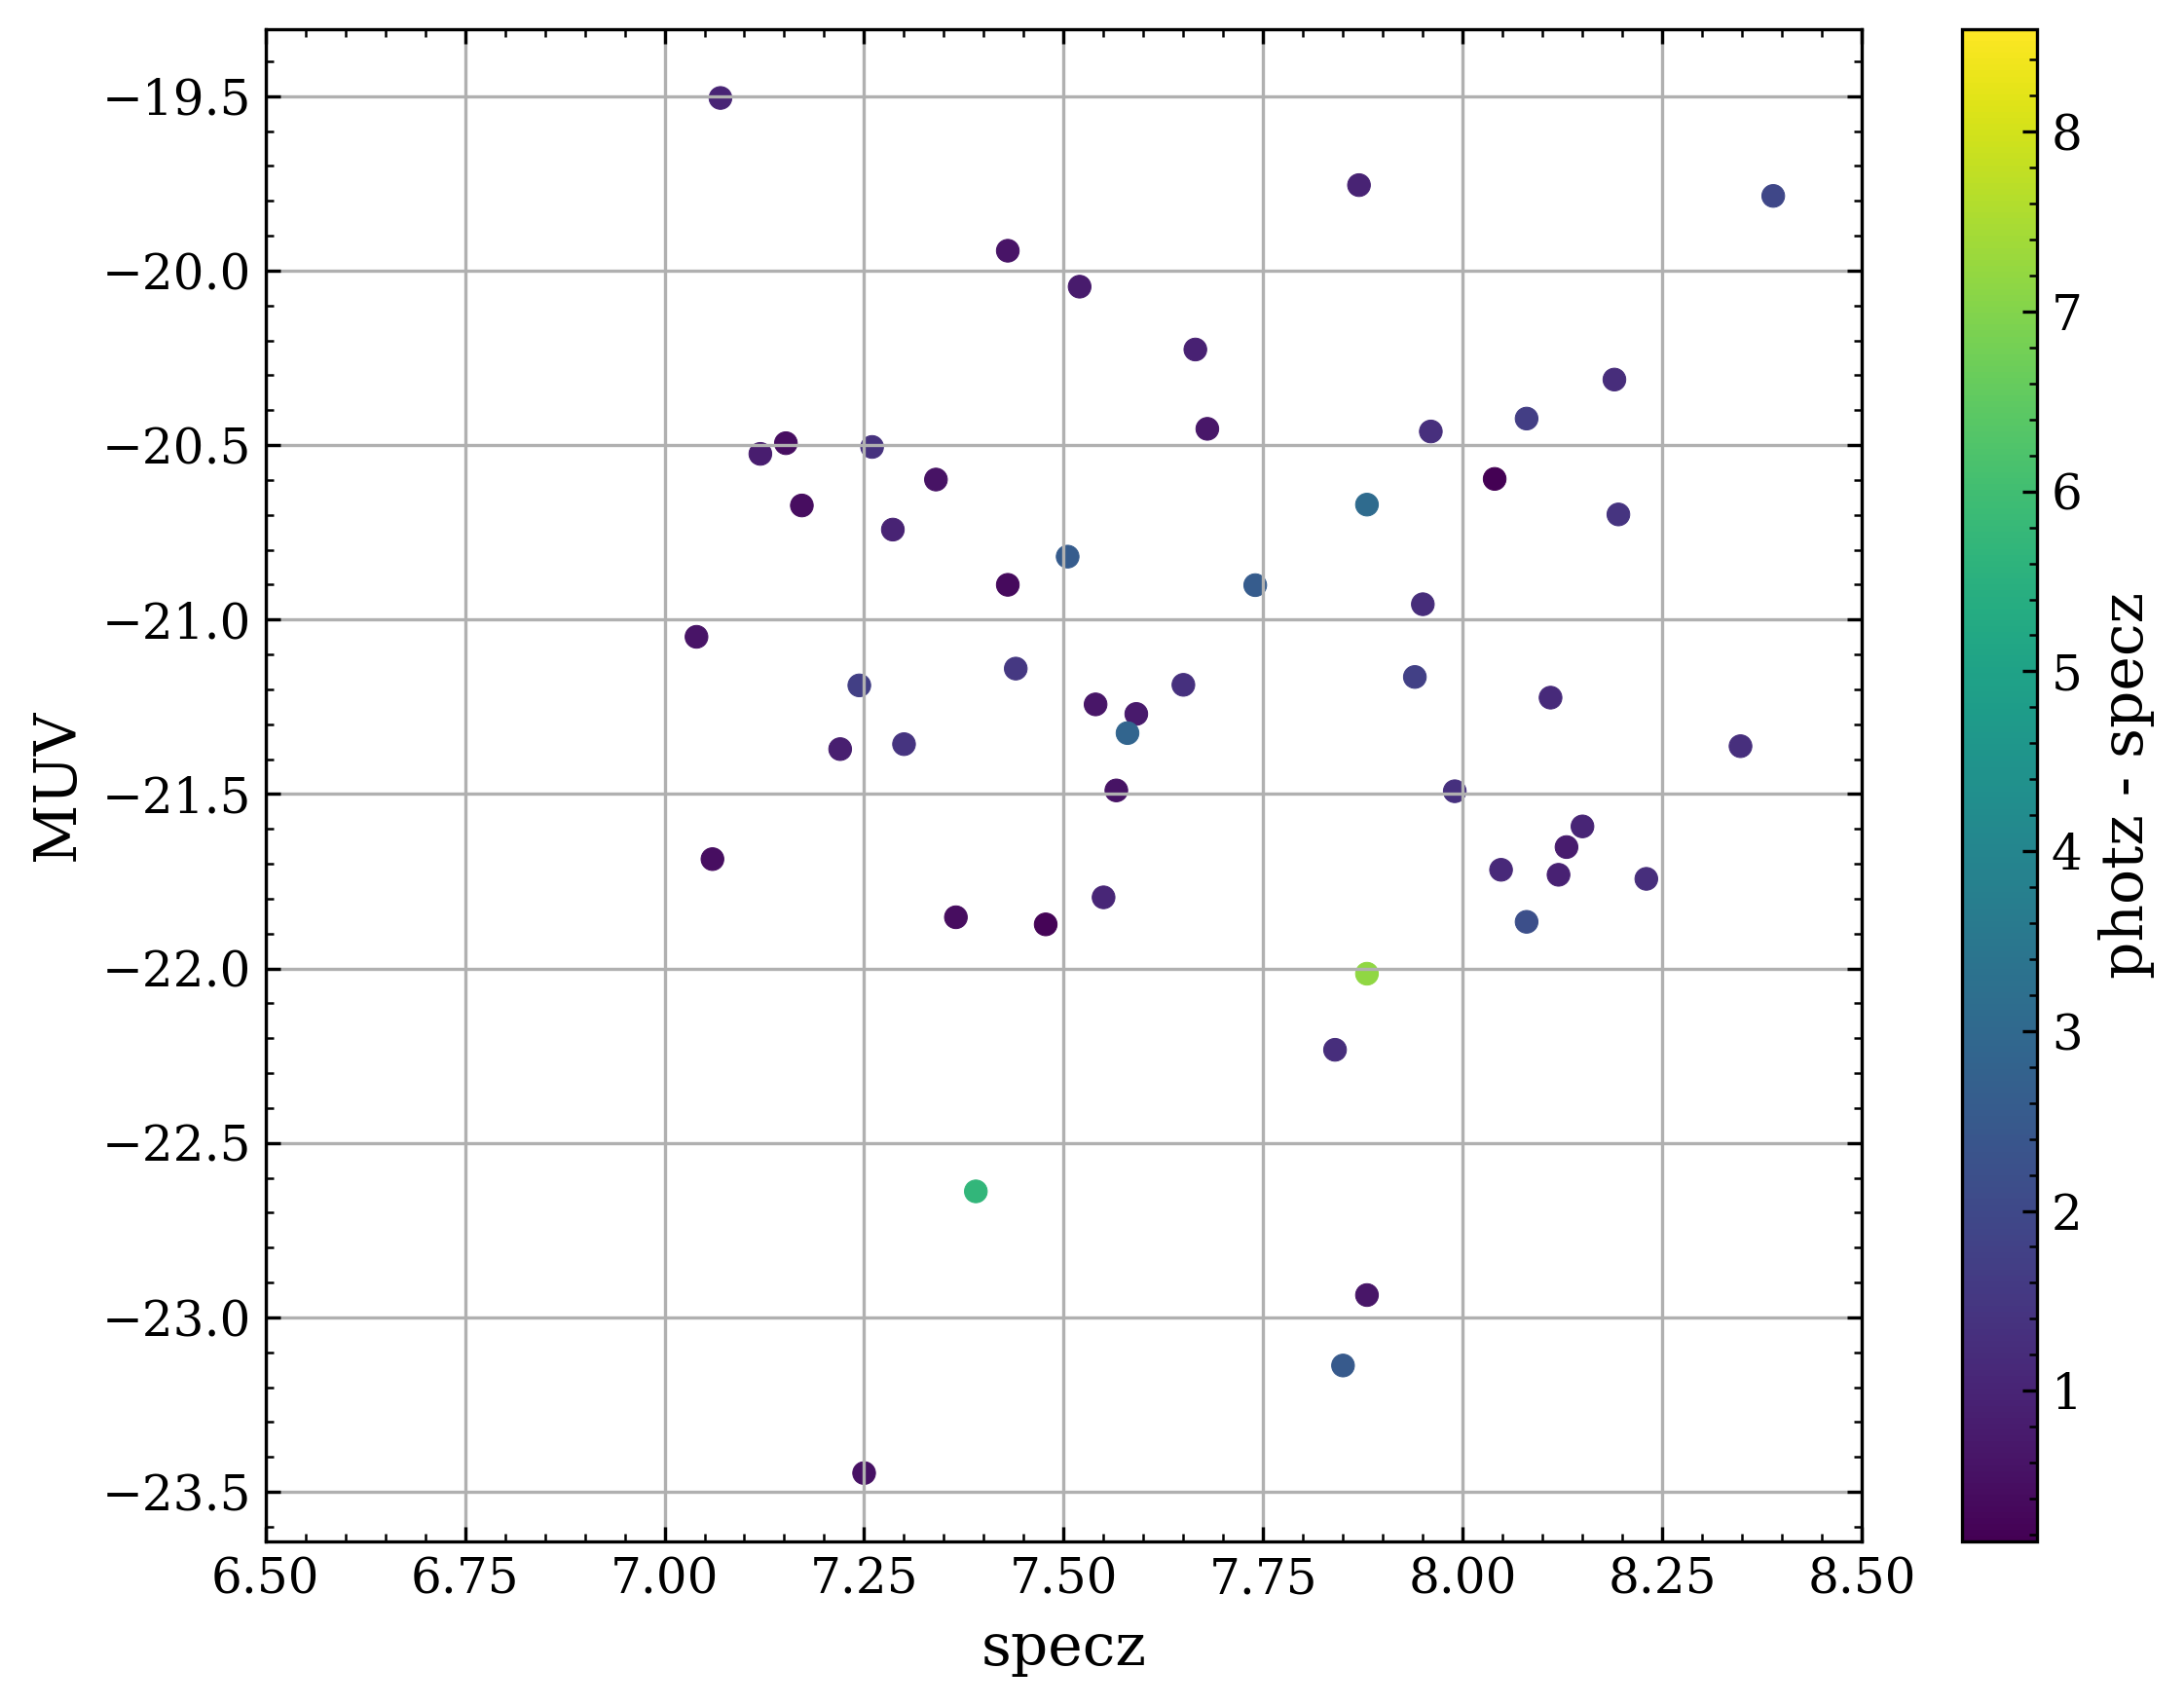

In [141]:
plt.figure(figsize=(8,6))
plt.scatter(ct['zguess'],ct['MUV_cand'],c=np.abs(ct['pz_cand']-ct['zguess']))
plt.xlim(6.5,8.5)
plt.colorbar(label='photz - specz')
plt.ylabel('MUV')
plt.xlabel('specz')

In [142]:
ct

mask,slit_no,obj,ypix_mospy,mospy_notes,pypeit_notes,wp,mp,keep,confidence,cquality,zguess,zmeasured,wave,ypix_slit,photoz,photoz_source,MUV,serendip_ra,serendip_dec,pypeit_ref_idx,pypeit_slit,pypeit_name,maskdef_id,objra,objdec,spat_pixpos,spat_fracpos,box_width,opt_fwhm,s2n,maskdef_extract,MUV_cand,Jmag_cand,pz_cand
str6,int64,str26,int64,str37,str54,float64,float64,int64,int64,float64,float64,float64,int64,float64,int64,str5,int64,str9,str7,int64,int64,str23,int64,float64,float64,float64,float64,int64,float64,float64,str5,float64,float64,float64
wmme02,1,B_W10617,--,l@10791,--,1.0,400.0,--,1,-1.0,7.87,--,10791,28.0,--,--,--,--,--,31,2672,SPAT2672-SLIT2672-DET01,1,214.92792,52.82428,2672.0,0.491,2,0.7,0.02,True,-19.755184209570096,27.411004342837593,8.819999999999856
wmme01,27,B_W18092,--,"fc,l@11109","fc,l@354,serendipl@9770",1.0,800.0,--,1,-1.0,8.15,--,11127,60.0,--,--,--,--,--,8,602,SPAT0618-SLIT0602-DET01,27,215.06646,52.94187,618.0,0.66,2,0.7,0.04,True,-21.593074051007843,25.62638152987077,7.109999999999893
wmme03,22,B_W22413,--,fc?,--,1.0,400.0,--,--,--,7.26,--,10050,68.0,--,--,--,--,--,12,880,SPAT0898-SLIT0880-DET01,22,214.87637,52.87766,898.0,0.684,2,1.0,0.18,True,-20.505584264652406,26.53663076682176,5.889999999999919
wmme01,14,B_W25438,--,l@10903,l@189?,1.0,400.0,--,1,-1.0,7.96,--,10849,18.0,--,--,--,--,--,21,1588,SPAT1580-SLIT1588-DET01,14,215.03512,52.98239,1580.0,0.414,2,0.7,0.0,True,-20.461237892732324,26.72230579947029,6.669999999999902
wmme01,11,B_W25641,--,l@9774?,"nl,nc",1.0,1000.0,0,0,-1.0,7.04,--,9774,35.0,--,--,--,--,--,24,1807,SPAT1811-SLIT1807-DET01,11,215.044,52.98964,1811.0,0.571,2,0.7,0.02,True,-21.049731055421198,25.94480512213988,6.439999999999907
wmme03,6,B_W27094,--,"diffuse,c,l@9930?checkalignment",--,1.0,400.0,--,1,0.0,--,--,9930,--,--,--,--,--,--,28,2200,SPAT2193-SLIT2200-DET01,6,214.94246,52.91473,2193.0,0.429,2,1.0,-0.23,True,-20.833757229886118,26.1362919979318,6.929999999999897
wmme03,21,B_W27805,--,"nl,nc",--,1.0,400.0,--,0,-1.0,--,--,--,--,--,--,--,--,--,13,987,SPAT0988-SLIT0987-DET01,21,214.89225,52.87743,988.0,0.51,2,1.0,0.05,True,-20.017336644592447,27.302637228919615,8.709999999999859
wmme01,4,B_W29881,--,"nl,serendipfc",l@1778(11413),1.0,400.0,--,1,0.5,8.389,--,11411,40.0,--,--,--,--,--,31,2465,SPAT2454-SLIT2465-DET01,4,215.0845,53.00869,2454.0,0.39,2,0.7,-0.01,True,-19.786167240264128,27.47712485796612,6.429999999999907
wmme01,2,B_W30645,--,"fc,nl",nl,1.0,1000.0,0,0,-1.0,--,--,--,--,--,--,--,--,--,33,2640,SPAT2636-SLIT2640-DET01,2,215.09504,53.01421,2636.0,0.455,2,0.7,0.07,True,-21.786524711568006,25.20359220267781,7.019999999999895
